In [1]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mtlb
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()


## Dataset description

- Description des données

 **Index**

- **DELIVERY_START** : date et heure de livraison de l'électricité

**Variables explicatives**

- **load_forecast** : prévision de consommation totale d'éléctricité en France
- **coal_power_available, gas_power_available, nucelear_power_available** : capacité de production totale d'électricité des centrales à charbon, gaz et nucléaire respectivement,
- **wind_power_forecasts_average, solar_power_forecasts_average** : moyenne de différentes prévisions de production totale d'électricité éolienne et solaire (respectivement),
- **wind_power_forecasts_std, solar_power_forecasts_std** : écart-type de ces mêmes prévisions,
- **predicted_spot_price** : prévision du prix SPOT de l'électricité issues d'un modèle interne de Elmy. Ce modèle est lancé chaque jour avant la fermeture des enchères SPOT pour le lendemain.

**Variable cible**

- **spot_id_delta** : l'écart entre le VWAP des transactions sur le marché infra-journalier (Intraday) et le prix SPOT pour 1MWh d'électricité (spot_id_delta = Intraday - SPOT) : si la valeur est positive, le prix Intraday est supérieur au prix SPOT et inversement

### Reading Dataset

In [2]:
# Charging the Dataset
df_train = pd.concat(
    [
        pd.read_csv("X_train_Wwou3IE.csv"),
        pd.read_csv("y_train_jJtXgMX.csv").drop(columns=["DELIVERY_START"]),
    ],
    axis=1,
).rename(columns={"nucelear_power_available": "nuclear_power_available"})# Correct the name of the "nucelear_power_available" column

### Dataset overview and Analysis

In [55]:
df_train.head(10)

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nuclear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,spot_id_delta
0,2022-01-01 02:00:00+01:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.000000,NaN,-36.874770
1,2022-01-01 03:00:00+01:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.000000,NaN,-12.643588
2,2022-01-01 04:00:00+01:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.000000,NaN,-1.950193
3,2022-01-01 05:00:00+01:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.000000,NaN,1.938272
4,2022-01-01 06:00:00+01:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.000000,NaN,0.199907
5,2022-01-01 07:00:00+01:00,45648.0,3386.0,11487.0,44118.0,3902.0,0.0,27.624052,0.000000,NaN,-0.943992
6,2022-01-01 08:00:00+01:00,45909.0,3386.0,11487.0,44118.0,4092.0,198.0,44.944701,6.195349,NaN,-2.770881
7,2022-01-01 09:00:00+01:00,47091.0,3386.0,11487.0,44118.0,4315.0,1012.0,30.505330,23.239957,NaN,-17.576596
8,2022-01-01 10:00:00+01:00,48300.0,3386.0,11487.0,44118.0,4436.0,2401.0,35.835910,44.450154,NaN,-12.352031
9,2022-01-01 11:00:00+01:00,49559.0,3386.0,11487.0,44118.0,4459.0,3699.0,57.670945,53.426489,NaN,-15.489499


In [4]:
df_train.shape

(10605, 11)

**Insight**:

The Dataframe has 10605 rows and 11 columns (with one which is the interest variable)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10605 entries, 0 to 10604
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DELIVERY_START                 10605 non-null  object 
 1   load_forecast                  9318 non-null   float64
 2   coal_power_available           10604 non-null  float64
 3   gas_power_available            10604 non-null  float64
 4   nuclear_power_available        10604 non-null  float64
 5   wind_power_forecasts_average   10581 non-null  float64
 6   solar_power_forecasts_average  10581 non-null  float64
 7   wind_power_forecasts_std       10581 non-null  float64
 8   solar_power_forecasts_std      10581 non-null  float64
 9   predicted_spot_price           1846 non-null   float64
 10  spot_id_delta                  10605 non-null  float64
dtypes: float64(10), object(1)
memory usage: 911.5+ KB


**Insight**:

- Most of the variables are Float 
- Delivery start variable is String type and will not be useful for the regression/classification task

In [6]:
# Displays some raws of the dataframe
print("\nSample of the dataset:")
df_train.sample(10)


Sample of the dataset:


,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nuclear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,spot_id_delta
8494,2022-12-31 00:00:00+01:00,49589.0,3386.0,11945.0,33274.0,14262.0,0.0,32.279215,0.000000,NaN,-2.212176
4922,2022-08-01 04:00:00+02:00,NaN,2226.0,11060.0,24925.0,1489.0,0.0,41.287015,0.000000,NaN,-18.756040
3394,2022-05-26 12:00:00+02:00,44965.0,2806.0,10840.0,25836.0,2387.0,6856.0,35.311314,55.652869,NaN,-0.857882
6751,2022-10-19 09:00:00+02:00,48921.0,2226.0,11480.0,29250.0,5733.0,1695.0,361.047353,17.271383,NaN,-11.617064
994,2022-02-11 12:00:00+01:00,71973.0,3386.0,11962.0,48647.0,2096.0,5421.0,53.224276,96.316268,NaN,-30.824428
5447,2022-08-23 01:00:00+02:00,38575.0,2226.0,11060.0,25410.0,1581.0,0.0,22.368570,0.000000,NaN,11.601610
6517,2022-10-09 15:00:00+02:00,38066.0,2226.0,11277.0,28810.0,1742.0,6305.0,110.180357,104.900872,NaN,-1.052888
3618,2022-06-05 20:00:00+02:00,40137.0,2226.0,10840.0,28340.0,4082.0,807.0,476.883873,9.529237,NaN,28.596498
8762,2023-01-11 04:00:00+01:00,48798.0,3386.0,11945.0,46265.0,11732.0,0.0,69.753558,0.000000,70.33,-9.196726
9137,2023-01-26 19:00:00+01:00,78492.0,3386.0,11945.0,45930.0,6681.0,0.0,507.564696,0.000000,197.53,8.728267


**Insight**:

Some Nan values must be further processed


In [7]:
#Display the dataset of raws of df with at least one Nan value
df_train[df_train.isnull().any(axis=1)]

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nuclear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,spot_id_delta
0,2022-01-01 02:00:00+01:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.0,NaN,-36.874770
1,2022-01-01 03:00:00+01:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.0,NaN,-12.643588
2,2022-01-01 04:00:00+01:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.0,NaN,-1.950193
3,2022-01-01 05:00:00+01:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.0,NaN,1.938272
4,2022-01-01 06:00:00+01:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.0,NaN,0.199907
...,...,...,...,...,...,...,...,...,...,...,...
10554,2023-03-27 21:00:00+02:00,52863.0,3386.0,11952.0,36990.0,1837.0,0.0,136.999062,0.0,NaN,1.540616
10555,2023-03-27 22:00:00+02:00,52783.0,3386.0,11952.0,36990.0,1812.0,0.0,128.421281,0.0,NaN,-1.485172
10556,2023-03-27 23:00:00+02:00,53274.0,3386.0,11952.0,36990.0,1854.0,0.0,106.112440,0.0,NaN,-6.687949
10557,2023-03-28 00:00:00+02:00,50798.0,3386.0,11952.0,36990.0,2050.0,0.0,76.348188,0.0,NaN,7.277778


**Insight**:

- The dataset is of very low quality with near to 80% of its rows filled with Nan values.
- It could be interesting to see how much are there for each column

In [8]:
def count_nan_by_column(dataframe):
    "Displays the number of Nan values for each column"

    for column in df_train.columns:
        col_value = dataframe[column]
        number_of_nan = col_value.isnull().sum()
        print(f"Number of Nan values for '{column}' column: {number_of_nan}")

    return 0


print("Here the number of Nan values for each column:")
print("______________________________________________")
count_nan_by_column(df_train)

Here the number of Nan values for each column:
______________________________________________
Number of Nan values for 'DELIVERY_START' column: 0
Number of Nan values for 'load_forecast' column: 1287
Number of Nan values for 'coal_power_available' column: 1
Number of Nan values for 'gas_power_available' column: 1
Number of Nan values for 'nuclear_power_available' column: 1
Number of Nan values for 'wind_power_forecasts_average' column: 24
Number of Nan values for 'solar_power_forecasts_average' column: 24
Number of Nan values for 'wind_power_forecasts_std' column: 24
Number of Nan values for 'solar_power_forecasts_std' column: 24
Number of Nan values for 'predicted_spot_price' column: 8759
Number of Nan values for 'spot_id_delta' column: 0


0

**Insight**:

- Most of the Nan values are in the "load_forecast" column with 1287 Nan values and in "predicted_spot_price" column with 8759 Nan values.
- Since there are only 8783 rows with Nan values, there are at least roughly 1000 rough with 2 Nan values
- These two columns must be analysed and processed properly

In [9]:
# Summarized Statistical description of the dataset
print("\nStatistical description:")
df_train.describe()


Statistical description:


,load_forecast,coal_power_available,gas_power_available,nuclear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,spot_id_delta
count,9318.000000,10604.000000,10604.000000,10604.000000,10581.000000,10581.000000,10581.000000,10581.000000,1846.000000,10605.000000
mean,53725.132968,2819.781592,11463.220671,35393.282252,4512.989415,1919.281353,125.399422,24.997384,140.256024,0.943358
std,11274.194929,495.103588,483.799154,7619.820162,3349.419356,2706.963383,132.152875,43.083977,33.922669,38.093819
min,30515.000000,1646.000000,9769.000000,22285.000000,592.000000,0.000000,1.830211,0.000000,42.420000,-1567.353547
25%,45336.500000,2226.000000,11140.000000,29005.000000,2036.000000,0.000000,46.818974,0.000000,119.405000,-11.934152
50%,51846.000000,2806.000000,11487.000000,32470.000000,3319.000000,149.000000,86.700163,3.507229,140.040000,0.059125
75%,62091.750000,3386.000000,11945.000000,43055.000000,5951.000000,3507.000000,155.325644,35.137019,160.765000,12.190489
max,85145.000000,3391.000000,11963.000000,50122.000000,15167.000000,10127.000000,1871.571992,745.261316,254.190000,658.961329


**Insight**

**load_forecast**: 
- Seems to be normally distributed
- High level std

**coal_power_available**: 
- Min and max value seem to be too far from the mean

**gas_power_available**: 
- Same thing

**nuclear_power_available**: 
- Same thing 
- High level std 

**wind_power_forecasts_average**: 
- The third quartile seems to be too far from th mean value compared to the std of the variable
- Max value very (very) high

**solar_power_forecasts_average**:
- At least 25 % of the data's equal to 0 
- Very high difference between the third quartile and the median
- Max value very far from the mean. This ca be explained by the fact that sunshine is'nt present everyday

**wind_power_forecasts_std**:
- Very high difference between the third quartile and the max value
- The distribution seems to be right skewed

**solar_power_forecasts_std**:
- Same thing

**predicted_spot_price**:
- Seems to be normally distributed

**spot_id_delta**:
- Seems to be normally distributed with mean near to 0
- The mean is equal to 0 beacause of the existence of negative values







In [10]:
# Check for duplicated rows
print("\nCheck for duplicated rows:")
df_train[df_train.duplicated(keep=False)].sort_values(by=df_train.columns.to_list())


Check for duplicated rows:


,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nuclear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,spot_id_delta


**Insight**:

- No duplicated rows


Histograms for all numrical features:


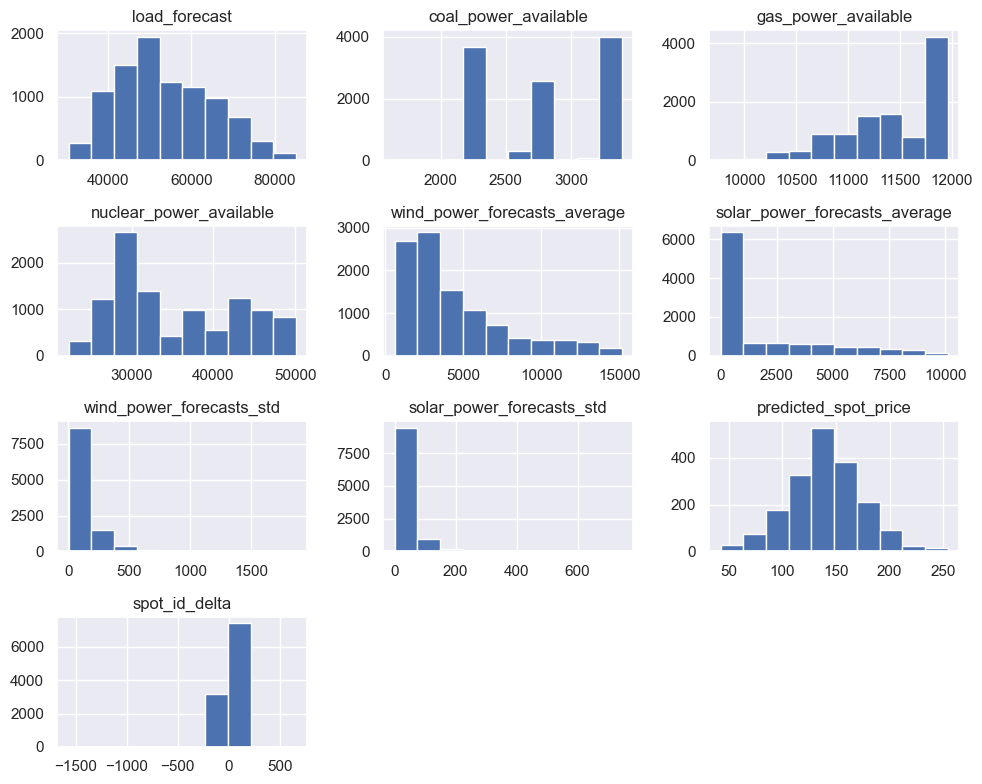

In [11]:
# Histograms for all numrical features
print("\nHistograms for all numrical features:")
df_train.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

**Insight**:
- The "predicted_spot_price" distribution seems to be gaussian. 
- The spot_id_delta column seems to be unbalanced it could be intersting to rebalance them using smote algorithm for example.

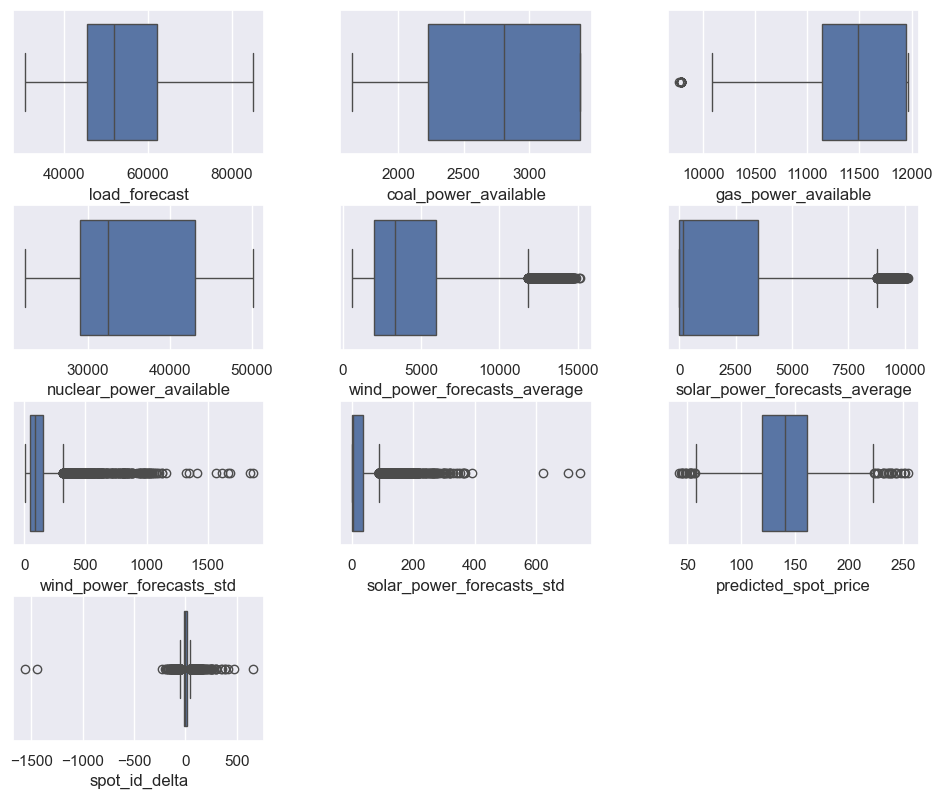

In [12]:
# Boxplots to check for outliers
numeric_cols = ["load_forecast", "coal_power_available", "gas_power_available", 
                "nuclear_power_available", "wind_power_forecasts_average", 
                "solar_power_forecasts_average", "wind_power_forecasts_std",
                "solar_power_forecasts_std", "predicted_spot_price", "spot_id_delta"]

# Defines the number of rows and columns of the future subplot
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

# Defines the figure
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 8))
fig.tight_layout()

for index, col in enumerate(numeric_cols):
    row_plot = index // n_cols
    col_plot = index % n_cols
    sns.boxplot(x=df_train[col], ax=axs[row_plot, col_plot])

# Remove empty subplots if the number of columns is odd
if len(numeric_cols) % n_cols != 0:
    for j in range(len(numeric_cols), n_rows * n_cols):
        fig.delaxes(axs.flatten()[j])

    


**Insight**:
- It seems the dataset presents some outliers. Maybe, for the normalization of the train set it could be inresting to use scaler by median instead of by mean


Correlation Matrix


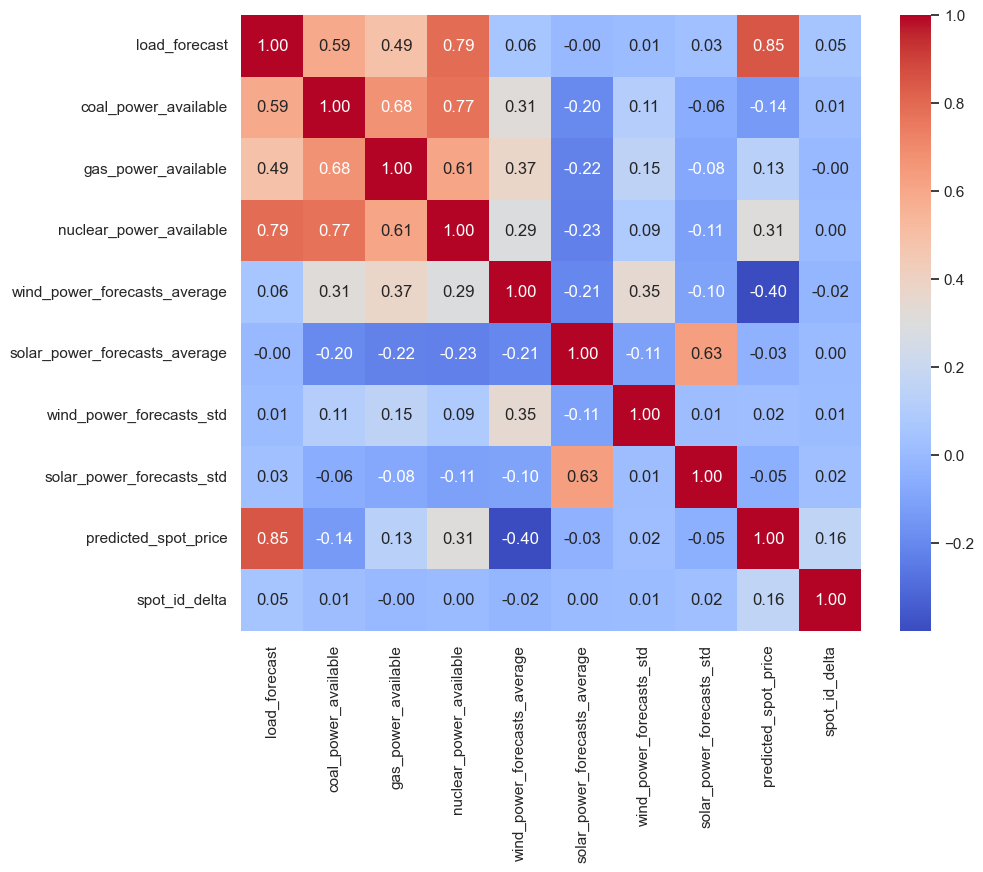

In [13]:
# Create a dataframe of numerical values in order to plot a correlation matrix
df_corr = df_train[numeric_cols]

print("\nCorrelation Matrix")
corr_matrix = df_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


**Insight**

- There is no variable which seems to have got a linear correlation with the variable of interest
- The variables : "coal_power_available", "gas_power_available", "nuclear_power_available", "load_forecast" have got important linear correlations with the variable "predicted_spot_price"
- The "predicted_spot_price" variable has got a very high linear correlation with the "load_forecast" variable. May be it would be safer to drop the "predicted_spot_price" column containing near to 80% of missing values instead of using a regressor to estimate them 

#### **Statistical comparison between train and test set**

In [56]:
df_test = pd.read_csv("X_test_GgyECq8.csv")
df_test.drop(columns={"DELIVERY_START", "predicted_spot_price"}, inplace=True)
df_test.rename(columns={"nucelear_power_available":"nuclear_power_available"}, inplace=True)

df_test

,load_forecast,coal_power_available,gas_power_available,nuclear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std
0,45814.0,3386.0,10902.0,36705.0,6359.0,0.0,56.764535,0.0
1,44084.0,3386.0,10902.0,36705.0,6469.0,0.0,54.262133,0.0
2,43281.0,3386.0,10902.0,36705.0,6511.0,0.0,78.105928,0.0
3,40825.0,3386.0,10902.0,36705.0,6628.0,0.0,78.187557,0.0
4,39181.0,3386.0,10902.0,36705.0,6700.0,0.0,96.765484,0.0
...,...,...,...,...,...,...,...,...
4937,49686.0,2226.0,11749.0,42980.0,4901.0,0.0,247.887323,0.0
4938,53397.0,2226.0,11749.0,42980.0,5584.0,0.0,343.192642,0.0
4939,50586.0,2226.0,11749.0,42980.0,6306.0,0.0,471.875973,0.0
4940,46777.0,2226.0,11749.0,42980.0,6959.0,0.0,595.528100,0.0


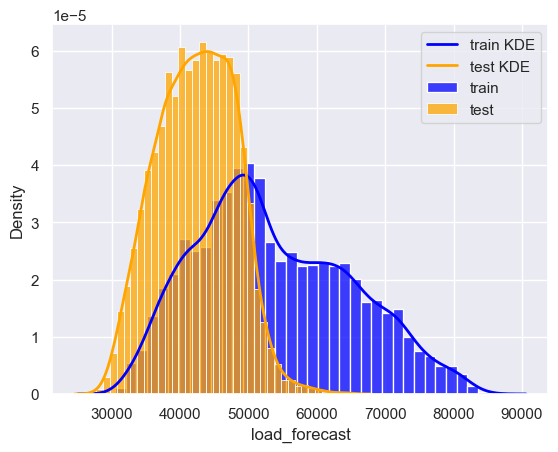

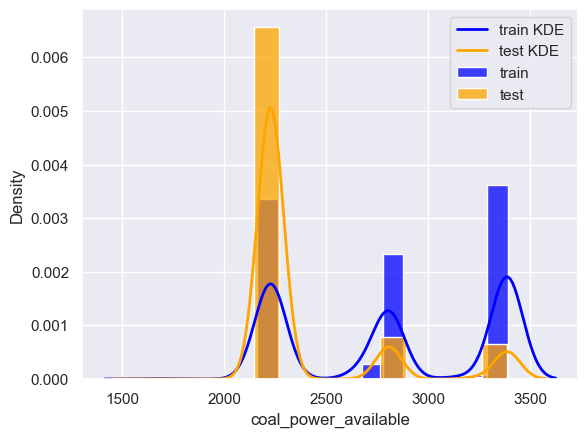

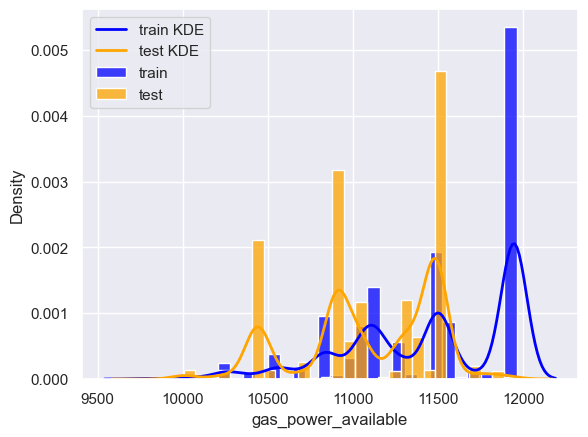

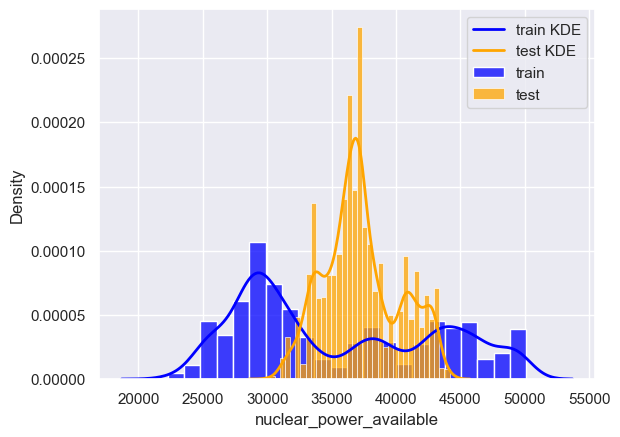

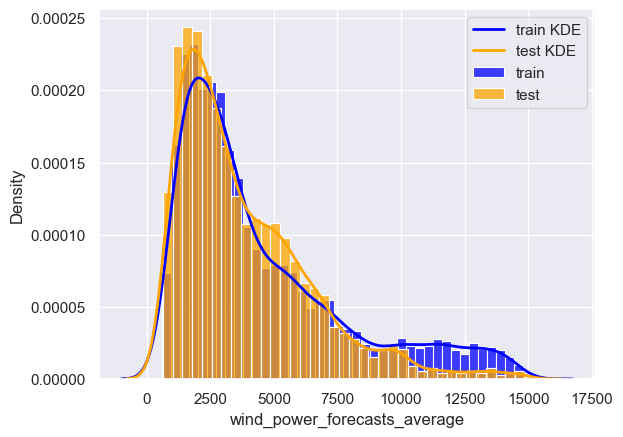

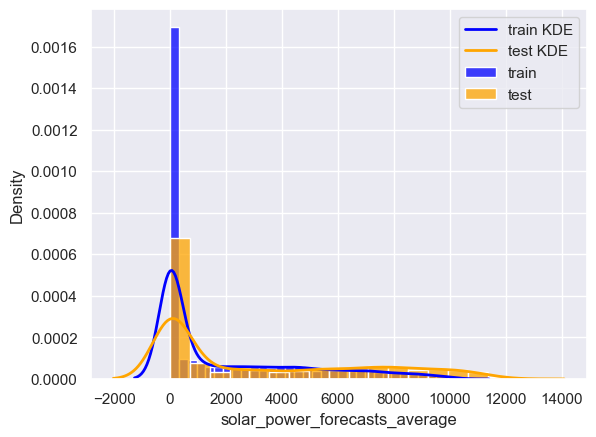

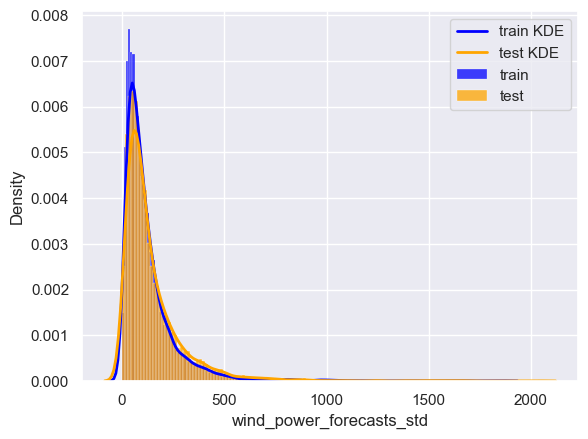

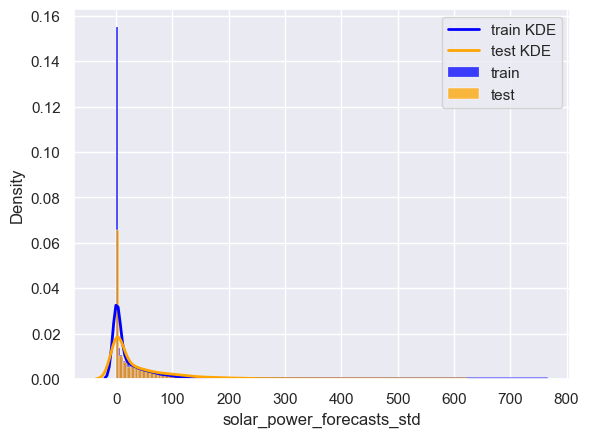

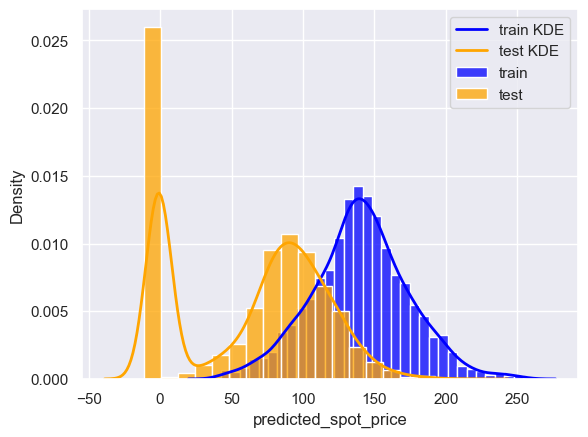

In [15]:
for col in df_test.columns:
    plt.figure()
    
    # Plot histograms for train and test
    sns.histplot(df_train[col], label='train', color='blue', kde=False, stat='density')
    sns.histplot(df_test[col], label='test', color='orange', kde=False, stat='density')
    
    # Overlay KDE plots for train and test
    sns.kdeplot(df_train[col], color='blue', label='train KDE', linewidth=2)
    sns.kdeplot(df_test[col], color='orange', label='test KDE', linewidth=2)
    
    plt.legend()
    plt.show()

**Insight:**
- **The columns :** "load_forecast", "nuclear_power_available", "gas_power_available" and "predicted_spot_price" seem to present some lags between Train and Test set distributions we must take care about further


## Data Preprocessing 

### Handling with Date column

In [16]:
# Verify if all the "DELIVERY_START" values are str objects
def verify_data_type(df=df_train, column="DELIVERY_START"):
    """
    Verify if all the values of the Date column of a DataFrame are string objects

    :param df: DataFrame
    :param column: The date column we want to analyse
    :return bool
    """

    bool = True
    for value in df[column]:
        bool = isinstance(value, str)
        if bool == False:
            return False
    return True


verify_data_type()

True

**Insight**
- All the Date values are string objects

In [17]:
from datetime import datetime
def standardize_convert_date(date_str):
    """
    Standardize and convert string objects date to date time object

    :param date_str: The date to standardize and convert to datetime object
    :return The same date in datetime object
    """
    if pd.isnull(date_str):
        return np.nan
    
    date_str = str(date_str).strip()
    date_str = str(date_str).replace('\n','')
    
    date_formats = [
        '%Y-%m-%d %H:%M:%S%z',  # 2023-10-14
        '%Y/%m/%d %H:%M:%S%z',  # 2023/10/14
        '%d %b %Y %H:%M:%S%z',  # 14 Oct 2023
    ]

    
    for date_format in date_formats:
        try:
            dt = pd.to_datetime(date_str, format=date_format)
            return dt
        except ValueError as e:
            logging.error(f"Error parsing date '{date_str}' with format '{date_format}': {str(e)}")

    logging.warning(f"Could not parse date '{date_str}' with any of the specified formats.")
    return np.nan

In [18]:
# Convert all dates of DELIVERY_START column to datetime objects
df_train["DELIVERY_START"] = df_train["DELIVERY_START"].apply(standardize_convert_date)

In [19]:
# Separate Year, Days and Hours
def separate_date(df):
    """ 
    Separate years, months, years and hours from date values and put each of them on a dedicated column
    
    :param df: The DataFrame to modify
    :return : THe modified DataFrame
    """

    # Convert the dataframe to a dictionnary in the "records" orientation, in order to loop on each raw
    dic_df = df.to_dict(orient="records")
    for raw in dic_df:
        date = raw["DELIVERY_START"]
        year = date.year
        month = date.month
        day = date.day
        hour = date.hour

        raw["Year"] = float(year)
        raw["Month"] = float(month)
        raw["Day"] = float(day) 
        raw["Hour"] = float(hour)
    
    new_df = pd.DataFrame(dic_df)
    date_columns = new_df.iloc[:, -4:]
    other_num_columns = new_df.iloc[:, 1:-4]

    new_df = pd.concat([date_columns, other_num_columns], axis=1)
    return new_df       

df_train_separated = separate_date(df=df_train)

In [20]:
df_train_separated.head(15)

,Year,Month,Day,Hour,load_forecast,coal_power_available,gas_power_available,nuclear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,spot_id_delta
0,2022.0,1.0,1.0,2.0,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.000000,NaN,-36.874770
1,2022.0,1.0,1.0,3.0,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.000000,NaN,-12.643588
2,2022.0,1.0,1.0,4.0,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.000000,NaN,-1.950193
3,2022.0,1.0,1.0,5.0,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.000000,NaN,1.938272
4,2022.0,1.0,1.0,6.0,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.000000,NaN,0.199907
5,2022.0,1.0,1.0,7.0,45648.0,3386.0,11487.0,44118.0,3902.0,0.0,27.624052,0.000000,NaN,-0.943992
6,2022.0,1.0,1.0,8.0,45909.0,3386.0,11487.0,44118.0,4092.0,198.0,44.944701,6.195349,NaN,-2.770881
7,2022.0,1.0,1.0,9.0,47091.0,3386.0,11487.0,44118.0,4315.0,1012.0,30.505330,23.239957,NaN,-17.576596
8,2022.0,1.0,1.0,10.0,48300.0,3386.0,11487.0,44118.0,4436.0,2401.0,35.835910,44.450154,NaN,-12.352031
9,2022.0,1.0,1.0,11.0,49559.0,3386.0,11487.0,44118.0,4459.0,3699.0,57.670945,53.426489,NaN,-15.489499


### Handling with missing values

In [21]:
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge

In [22]:
# Imputation of missing values using Bayesian Ridge regressor
# For normalization a Robust scaler using the median of the distributions beacause of the presence of a lot of outliers
# in some columns of the dataset
scaler_imput = RobustScaler() 
df_train_scaled = scaler_imput.fit_transform(df_train_separated)

imputer = IterativeImputer(BayesianRidge())
df_train_imputed = pd.DataFrame(imputer.fit_transform(df_train_scaled), columns=df_train_separated.columns)
df_train_imputed = pd.DataFrame(scaler_imput.inverse_transform(df_train_imputed), columns=df_train_separated.columns)


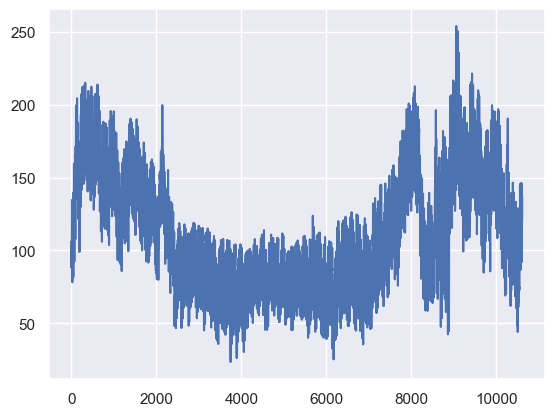

In [23]:
plt.plot(df_train_imputed["predicted_spot_price"])

In [24]:
# Create a column of labels. 0 when spot_id_delta is negative and 1 otherwise
def sign(number):
    """Returns the sign of the number in parameter"""
    if number < 0:
        return -1
    else:
        return 1
    
def create_labels_column(df=df_train_imputed):
    """Add to the dataframe a column of labels. 0 if the "spot_id_delta is negative, 1 otherwise"""
    labels_column = [sign(value) for value in df["spot_id_delta"]]
    df["labels"] = labels_column

    return df

create_labels_column()
df_train_imputed

,Year,Month,Day,Hour,load_forecast,coal_power_available,gas_power_available,nuclear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,spot_id_delta,labels
0,2022.0,1.0,1.0,2.0,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.000000,100.166566,-36.874770,-1
1,2022.0,1.0,1.0,3.0,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.000000,91.730677,-12.643588,-1
2,2022.0,1.0,1.0,4.0,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.000000,88.410003,-1.950193,-1
3,2022.0,1.0,1.0,5.0,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.000000,88.178284,1.938272,1
4,2022.0,1.0,1.0,6.0,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.000000,90.701018,0.199907,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10600,2023.0,3.0,29.0,19.0,50814.0,3386.0,11952.0,38320.0,7552.0,651.0,247.408490,7.821622,108.110000,6.029303,1
10601,2023.0,3.0,29.0,20.0,50628.0,3386.0,11952.0,38320.0,8338.0,109.0,155.795012,2.534054,125.660000,13.576177,1
10602,2023.0,3.0,29.0,21.0,48201.0,3386.0,11952.0,38320.0,9115.0,0.0,126.884684,0.000000,138.010000,17.478945,1
10603,2023.0,3.0,29.0,22.0,47967.0,3386.0,11952.0,38320.0,9636.0,0.0,156.669189,0.000000,136.740000,17.559407,1


## Apply Some Classification models to the Dataset

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix

In [47]:
# Define the features dataset and the labels dataset
X = df_train_imputed.drop(columns={"spot_id_delta", "labels", "predicted_spot_price"})
y = df_train_imputed["labels"]

# Separate them to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Scale them
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [48]:
X_test_scaled

array([[ 0.        ,  0.85714286,  0.66666667, ..., -0.04311343,
         0.005202  , -0.09900676],
       [ 1.        , -0.42857143, -0.13333333, ...,  2.26099537,
        -0.71977118,  0.2392242 ],
       [ 0.        ,  0.85714286, -0.6       , ..., -0.04311343,
        -0.53649039, -0.09900676],
       ...,
       [ 0.        , -0.42857143, -0.86666667, ..., -0.04311343,
         1.67687845, -0.09900676],
       [ 0.        , -0.42857143, -1.        , ...,  0.19618056,
         0.89539423,  1.38715106],
       [ 0.        ,  1.        ,  0.53333333, ...,  0.00694444,
        -0.02602733, -0.04721877]])

In [49]:
# Create, fit the svm model on the train set
classifier = RandomForestClassifier(n_estimators=500, random_state=42)
print(X_train.columns)
classifier.fit(X_train_scaled, y_train)
y_pred = classifier.predict(X_test_scaled)

print(accuracy_score(y_test, y_pred))
confusion_matrix(y_test, y_pred)



Index(['Year', 'Month', 'Day', 'Hour', 'load_forecast', 'coal_power_available',
       'gas_power_available', 'nuclear_power_available',
       'wind_power_forecasts_average', 'solar_power_forecasts_average',
       'wind_power_forecasts_std', 'solar_power_forecasts_std'],
      dtype='object')
0.7948717948717948


array([[1037,  283],
       [ 261, 1071]])

Here some functions which could be useful for the features selection

In [50]:
# Import and read the Test set
df_test = pd.read_csv("X_test_GgyECq8.csv", sep=",").rename(columns={"nucelear_power_available":"nuclear_power_available"})

# Apply to the test_set the same transformations as for the train set:
# On its dates 
df_test["DELIVERY_START"] = df_test["DELIVERY_START"].apply(standardize_convert_date)
df_test_separated = separate_date(df=df_test)

scaler_imput_test = RobustScaler()
df_test_scaled = scaler_imput_test.fit_transform(df_test_separated)

imputer_test = IterativeImputer(BayesianRidge())
df_test_imputed = pd.DataFrame(imputer_test.fit_transform(df_test_scaled), columns=df_test_separated.columns)
df_test_imputed = pd.DataFrame(scaler_imput_test.inverse_transform(df_test_imputed), columns=df_test_separated.columns)

df_test_imputed_scaled = scaler.transform(df_test_imputed.drop(columns={"predicted_spot_price"}))




In [51]:
y_pred_test = classifier.predict(df_test_imputed_scaled)
print(y_pred_test.sum())

-2160


In [54]:
submission = pd.DataFrame(
                           {"DELIVERY_START": DELIVERY_START,
                           "spot_id_delta": y_pred_test}
                           )
print(submission)
print(df_test)
submission_csv = submission.to_csv("submission_Lelouche_iaa.csv", index=False, sep=",")

                 DELIVERY_START  spot_id_delta
0     2023-04-02 00:00:00+02:00             -1
1     2023-04-02 01:00:00+02:00             -1
2     2023-04-02 02:00:00+02:00             -1
3     2023-04-02 03:00:00+02:00             -1
4     2023-04-02 04:00:00+02:00             -1
...                         ...            ...
4937  2023-10-24 19:00:00+02:00              1
4938  2023-10-24 20:00:00+02:00              1
4939  2023-10-24 21:00:00+02:00              1
4940  2023-10-24 22:00:00+02:00              1
4941  2023-10-24 23:00:00+02:00              1

[4942 rows x 2 columns]
                DELIVERY_START  load_forecast  coal_power_available  \
0    2023-04-02 00:00:00+02:00        45814.0                3386.0   
1    2023-04-02 01:00:00+02:00        44084.0                3386.0   
2    2023-04-02 02:00:00+02:00        43281.0                3386.0   
3    2023-04-02 03:00:00+02:00        40825.0                3386.0   
4    2023-04-02 04:00:00+02:00        39181.0           

In [53]:
def extract_feature_importances(
    X_train: pd.DataFrame, 
    X_test: pd.DataFrame, 
    y_train: Union[pd.Series, np.ndarray], 
    y_test: Union[pd.Series, np.ndarray], 
    da_method: str
) -> pd.DataFrame:
    """
    Train a Random Forest classifier on training data, evaluate it on test data, and extract feature importances.

    Parameters:
    -----------
    X_train : pandas.DataFrame
        The training dataset containing features for training.

    X_test : pandas.DataFrame
        The testing dataset containing features for evaluation.

    y_train : pandas.Series or array-like
        The target labels corresponding to the training dataset.

    y_test : pandas.Series or array-like
        The target labels corresponding to the testing dataset.

    da_method : str
        A string indicating the data augmentation method used (for display purposes). 
        If the data are real the string "no" must be entered

    Returns:
    --------
    pandas.DataFrame
        A DataFrame sorted by feature importance, containing feature names and their corresponding importance scores.
    """

    # Define a Random Forest classifier and train it on the training data
    rf_selection = RandomForestClassifier(n_estimators=1000, random_state=42)
    rf_selection.fit(X_train, y_train)

    # Test the model on the testing dataset
    y_rf_selection_predict = rf_selection.predict(X_test)

    # Compute and print the accuracy score of the model
    accuracy = accuracy_score(y_test, y_rf_selection_predict)
    if da_method != "no" :
        print(
            f"Accuracy score of a Random Forest classifier trained on augmented data by {da_method} method: {accuracy}"
        )
    else:
        print(
            f"Accuracy score of a Random Forest classifier trained on real data: {accuracy}"
        )

    # Retrieve the importance of each feature used in the model training
    importances = rf_selection.feature_importances_
    feature_names = X_train.columns

    # Store all the feature importances in a dictionary to convert it into a DataFrame
    dic_feature_importance = {name: [] for name in feature_names}
    for index, name in enumerate(dic_feature_importance):
        dic_feature_importance[name].append(importances[index])

    # Convert the dictionary to a DataFrame
    df_feature_importance = pd.DataFrame(dic_feature_importance)

    # Transpose and sort the DataFrame by feature importance values
    df_feature_importance = df_feature_importance.T
    df_feature_importance.sort_values(by=0, ascending=False, inplace=True)
    df_feature_importance = df_feature_importance.T

    # Return the sorted DataFrame of feature importances
    return df_feature_importance


def select_best_threshold(
    df_importance: pd.DataFrame,
    classif_method: str,
    list_threshold: List[float],
    X: Optional[pd.DataFrame] = [],
    y: Optional[Union[pd.Series, np.ndarray]] = [],
    X_train: Optional[pd.DataFrame] = None,
    X_test: Optional[pd.DataFrame] = None,
    y_train: Optional[Union[pd.Series, np.ndarray]] = None,
    y_test: Optional[Union[pd.Series, np.ndarray]] = None,
) -> pd.DataFrame:
    """
    Select the best threshold for feature selection based on model accuracy and evaluate the model.

    Parameters:
    -----------
    df_importance : pandas.DataFrame
        DataFrame containing feature importances extracted from a trained model.

    classif_method : str
        The classification method to be used ('svm', 'rf', 'knn', 'gnb').

    list_threshold : list of float
        A list of threshold values to test for selecting important features.

    X : pandas.DataFrame, optional
        The complete dataset containing all features (default is None).

    y : pandas.Series or array-like, optional
        The target labels corresponding to the dataset (default is None).

    X_train : pandas.DataFrame, optional
        The training dataset if provided directly (default is None).

    X_test : pandas.DataFrame, optional
        The testing dataset if provided directly (default is None).

    y_train : pandas.Series or array-like, optional
        The training labels if provided directly (default is None).

    y_test : pandas.Series or array-like, optional
        The testing labels if provided directly (default is None).
    
    Notes: Depending on the most useful case, the user can choose between entering the train and test sets or the full characteristics and labels sets.
    ------

    Returns:
    --------
    pandas.DataFrame
        A DataFrame of the selected features using the best threshold.
    sklearn.model
        The best model according to the accuracy_score evaluation
    """

    # Define a dictionary to store accuracies for each threshold
    dic_accuracies = {f"{threshold}": [] for threshold in list_threshold}
    best_threshold = list_threshold[0]  # Initialize the best threshold
    best_model = RandomForestClassifier()

    # If X is provided, split into training and testing sets, and scale features
    if X != []:
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = X_train.copy()
        X_test_scaled = X_test.copy()
        for column in X_train.columns:
            X_train_scaled[column] = scaler.fit_transform(X_train[[column]])
            X_test_scaled[column] = scaler.transform(X_test[[column]])
        X_train = X_train_scaled
        X_test = X_test_scaled

    # Loop over each threshold value to evaluate model performance
    for threshold in list_threshold:
        # Select features that have importance values greater than the current threshold
        selected_features = [
            feature
            for feature in df_importance.columns
            if (df_importance[feature] >= threshold).any()
        ]
        X_train_threshold = X_train[selected_features]
        X_test_threshold = X_test[selected_features]
        X_threshold = pd.concat([X_train_threshold, X_test_threshold])

        # Defines the classifier based on the specified method
        if classif_method == "svm":
            model_threshold = SVC(kernel="rbf", probability=True)
        elif classif_method == "rf":
            model_threshold = RandomForestClassifier(n_estimators=500, random_state=42)
        elif classif_method == "knn":
            model_threshold = KNeighborsClassifier()
        elif classif_method == "gnb":
            model_threshold = GaussianNB()

        # Train the model on the selected features and evaluate it
        model_threshold.fit(X_train_threshold, y_train)
        y_model_threshold_pred = model_threshold.predict(X_test_threshold)

        # Compute the ROC AUC score
        y_model_threshold_scores = model_threshold.predict_proba(X_test_threshold)[:, 1]
        auc_score = roc_auc_score(y_test, y_model_threshold_scores)

        # Compute the accuracy score for this threshold
        accuracy_threshold = accuracy_score(y_test, y_model_threshold_pred)

        # Store the accuracy score in the dictionary
        dic_accuracies[f"{threshold}"].append(accuracy_threshold)

        # Update the best threshold if the current threshold gives better accuracy
        best_accuracy = dic_accuracies[f"{best_threshold}"]
        if best_accuracy <= dic_accuracies[f"{threshold}"]:
            best_threshold = threshold
            best_auc_score = auc_score
            best_confusion_matrix = confusion_matrix(y_test, y_model_threshold_pred)
            best_model = model_threshold

    # Select features using the best threshold
    selected_features = [
        feature
        for feature in df_importance.columns
        if (df_importance[feature] >= best_threshold).any()
    ]
    df_selected_best_threshold = X_train[selected_features]

    # Display the results
    print(f"Here are the results and metrics for the {classif_method} model:")
    print("----------------------------------------------------------")
    print(f"The best threshold is: {best_threshold}")
    print("Selected features:", df_selected_best_threshold.columns)
    print(f"Accuracy score: {best_accuracy}")
    print(f"AUC score: {best_auc_score}")
    print(f"Confusion Matrix:\n{best_confusion_matrix}")
    print(f"Here the dic_accuracies: {dic_accuracies}")


    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        best_confusion_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Negative", "Positive"],
        yticklabels=["Negatuve", "Positive"],
    )
    plt.xlabel("Predictions")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    return df_selected_best_threshold, best_model

NameError: name 'Union' is not defined

In [22]:
#list_threshold = df_importance.iloc[0, :]
#print(list_threshold)
#df_selected_best_threshold, model_selected_best_threshold = select_best_threshold(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, df_importance=df_importance, classif_method="rf", list_threshold=list_threshold)

**Insight**:
The features selection by features importances seems to be unuseful when Nan values are replaced by -1

In [23]:
#df_selected_best_threshold
#list_threshold = df_importance.iloc[0, :]
#print(list_threshold)

In [24]:
#y_predict = model_selected_best_threshold.predict(df_test)

In [ ]:
# Because of the difficulties of the selected model to be tested on the test set we train a new Random Forest Classifier on the train set
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train_scaled, y_train)

y_pred = gb_model.predict(X_test_scaled)
print(f"The Accuracy Score for this model is : {accuracy_score(y_test, y_pred)}")
gb_model.get_params()

In [ ]:
# Scale the test set
y_pred_bis = gb_model.predict(df_test)
print(DELIVERY_START)
print(y_pred_bis.sum())

In [ ]:
sns.histplot(y_pred_bis)